**Project Title:** Forecast the Short Term Electricity Load Demand for Panama Power System

**Project Objective:** The main objective of this analysis is to forecast the short term electricity demand (MWh) for Panama power system using a Deep Learning Model.

In [ ]:
#Mount your Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/3546 Deep Learning/data')
import pandas as pd
from datetime import datetime
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
import math
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Read the ontinuous dataset file which has 17 features. 
# The dataset is available at https://www.kaggle.com/ernestojaguilar/shortterm-electricity-load-forecasting-panama,
df_continuous = pd.read_csv('continuous dataset.csv')
df_continuous.head(5)

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


In [ ]:
# Get the datetime and national load demand features
load_demand = df_continuous[['datetime','nat_demand']]
load_demand.head(5)

,datetime,nat_demand
0,2015-01-03 01:00:00,970.3450
1,2015-01-03 02:00:00,912.1755
2,2015-01-03 03:00:00,900.2688
3,2015-01-03 04:00:00,889.9538
4,2015-01-03 05:00:00,893.6865


In [ ]:
# Remove seconds from datetime
load_demand['datetime'] = pd.to_datetime(load_demand['datetime'])
load_demand['datetime'] = load_demand['datetime'].dt.strftime('%m/%d/%Y %H:%M')

In [ ]:
# Get the size of the load demand dataset
load_demand.shape

(48048, 2)

**Exploratory Data Analysis**

In [ ]:
# Examine the load demand dataset
load_demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48048 entries, 0 to 48047
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    48048 non-null  object 
 1   nat_demand  48048 non-null  float64
dtypes: float64(1), object(1)
memory usage: 750.9+ KB


In [ ]:
# Get statistical information for the load demand data
load_demand.describe()

,nat_demand
count,48048.000000
mean,1182.868647
std,192.068896
min,85.192500
25%,1020.056900
50%,1168.427700
75%,1327.563950
max,1754.882000


In [ ]:
# Set datetime as index
load_demand.set_index(load_demand.datetime, inplace=True)

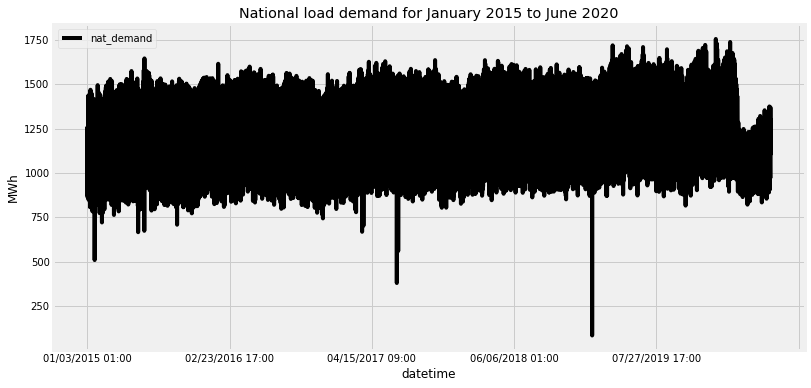

In [ ]:
# Plot national load demand from January 2015 to June 2020
plt.figure(figsize=(12,6))
demand2015_2020 = load_demand['nat_demand'].loc[:'06/26/2020 00:00']
demand2015_2020.plot(color="black")
plt.title('National load demand for January 2015 to June 2020')
plt.ylabel('MWh')
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/3546 Deep Learning/Final Project/load_demand_jan2015_jun2020.png')
plt.legend()
plt.show()

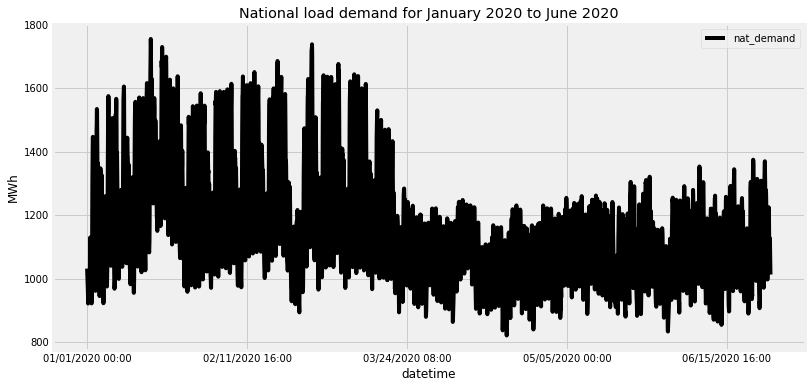

In [ ]:
# Plot national load demand from June 2019 to June 2020
demand2019_2020 = load_demand['nat_demand'].loc['01/01/2020 00:00':]
plt.figure(figsize=(12,6))
demand2019_2020.plot(color="black")
plt.title('National load demand for January 2020 to June 2020')
plt.ylabel('MWh')
plt.legend()
plt.show()

The load demand plot for January 2020 to June 2020 shows a significant drop in demand due the to start of the COVID-19 pandemic in March 2020. Therefore the dataset for this project will use the load demand data from January 2015 to month end of February 2020


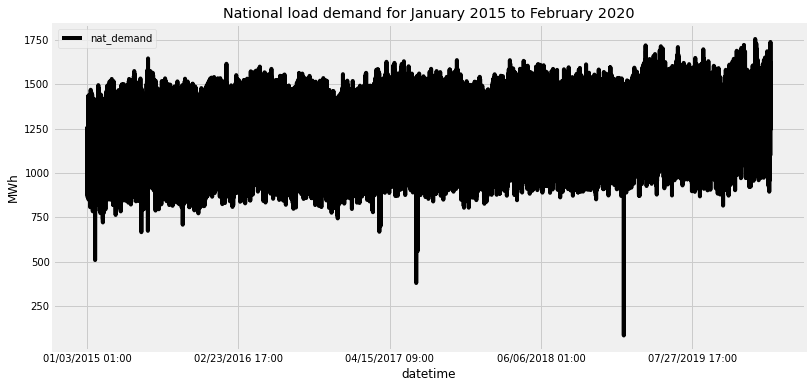

In [ ]:
# Plot the load demand from January 2015 to the month end of February 2020
data = load_demand['nat_demand'].loc[:'02/28/2020 23:00']
plt.figure(figsize=(12,6))
data.plot(color="black")
plt.title('National load demand for January 2015 to February 2020')
plt.ylabel('MWh')
plt.legend()
plt.show()

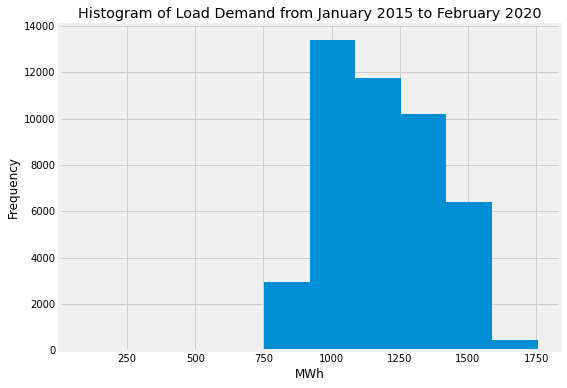

In [ ]:
# plot a histogram of load demand
plt.figure(figsize=(8,6))
data.hist()
plt.title('Histogram of Load Demand from January 2015 to February 2020')
plt.xlabel('MWh')
plt.ylabel('Frequency')
plt.show()

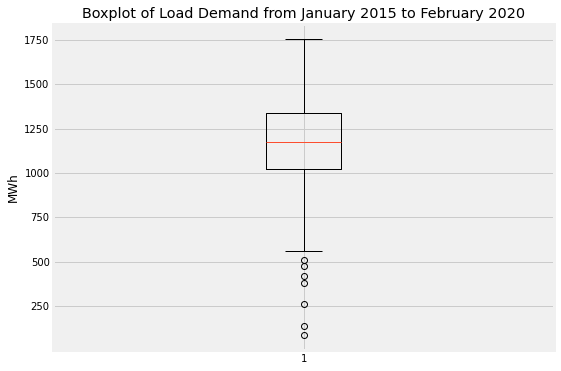

In [ ]:
# Plot Boxplot of Load Demand
plt.figure(figsize=(8,6))
plt.boxplot(data)
plt.title('Boxplot of Load Demand from January 2015 to February 2020')
plt.ylabel('MWh')
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/3546 Deep Learning/Final Project/boxplot_jan2015_feb2020.png')
plt.show()

The load demand plot shows that there are several outlier values which may have been due to power system equipment failure. Replace the outliers with a new value of 500 MWh

In [ ]:
data = data.round(decimals=2)

In [ ]:
# Replace outlier1: 85.19
outlier1 = data == 85.19
data[outlier1] = 500.00

In [ ]:
# Replace outlier2: 263.62
outlier2 = data == 263.62
data[outlier2] = 500.00

In [ ]:
# Replace outlier3: 380.59
outlier3 = data == 380.59
data[outlier3] = 500.00

In [ ]:
# Scale the load demand dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = pd.DataFrame(data)
data_scaled = scaler.fit_transform(data)
data_scaled = data_scaled.flatten()

In [ ]:
data_scaled.shape

(45191,)

In [ ]:
# Create train, validation and test datasets
def get_dataset_partitions(data_scaled, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
    
    # Only allows for equal validation and test splits
    assert val_split == test_split 
    
    val_test_index = int((val_split+test_split)*len(data_scaled)//2)
    indices = [int(train_split * len(data_scaled)), int(train_split* len(data_scaled)+val_test_index)]
    
    train_ds, val_ds, test_ds = np.split(data_scaled, indices, axis=0)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions(data_scaled)
print('train data size:', len(train_ds))
print('validation data size:', len(val_ds))
print('test data size:', len(test_ds))

train data size: 36152
validation data size: 4519
test data size: 4520


In [ ]:
# Convert the time values to numpy
time_index = np.array(load_demand['datetime'].loc[:'02/28/2020 23:00'])

train_index = time_index[:len(train_ds)]
val_index = time_index[len(train_ds):len(train_ds)+len(val_ds)]
test_index = time_index[-len(test_ds):]

print('train index size:', len(train_index))
print('val index size:', len(val_index))
print('test index size:', len(test_ds))

train index size: 36152
val index size: 4519
test index size: 4520


In [ ]:
# Show samples of train, validate and test datasets
print('train data:', train_ds[-3:])
print('train time index:', train_index[-3:])
print('val data:', val_ds[:3])
print('val time index:', val_index[:3])
print('val data:', val_ds[-3:])
print('val time index:', val_index[-3:])
print('test data:', test_ds[:3])
print('test time index:', test_index[:3])

train data: [-1.20991919 -1.2709838  -0.85084898]
train time index: ['02/17/2019 06:00' '02/17/2019 07:00' '02/17/2019 08:00']
val data: [-0.63797311 -0.36934036 -0.17079019]
val time index: ['02/17/2019 09:00' '02/17/2019 10:00' '02/17/2019 11:00']
val data: [0.49483982 0.28685943 0.20822264]
val time index: ['08/24/2019 13:00' '08/24/2019 14:00' '08/24/2019 15:00']
test data: [-0.02387441 -0.16161762  0.01132148]
test time index: ['08/24/2019 16:00' '08/24/2019 17:00' '08/24/2019 18:00']


In [ ]:
# Utility function for time series data generation in batches

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer, seed=42).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def windowed_dataset_test(series, window_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1][np.newaxis], window[-1][np.newaxis]))
    return dataset

In [ ]:
# Generate train, validation and test datasets
window_size = 96
batch_size = 128
shuffle_buffer = 128

train_dataset = windowed_dataset(train_ds, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer)
val_dataset = windowed_dataset(val_ds, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer)
test_dataset = windowed_dataset_test(test_ds, window_size=window_size)

**Build a SimpleRNN model**

In [ ]:
# Create a SimpleRNN model with 2 layers
rnn_model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    keras.layers.SimpleRNN(300, return_sequences=True),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1)
])
rnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_10 (Lambda)           (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 300)         90600     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 100)         40100     
_________________________________________________________________
dense_8 (Dense)              (None, None, 1)           101       
Total params: 130,801
Trainable params: 130,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile and train SimpleRNN model with learning rate = 1e-3
learning_rate = 1e-3
epochs = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,restore_best_weights=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
rnn_model.compile(loss=tf.keras.losses.MAE, optimizer=optimizer, metrics=["mae"])
history_rnn = rnn_model.fit(train_dataset,
                         epochs=epochs,
                         validation_data=val_dataset,
                         callbacks=[callback],                      
                         verbose=2)

Epoch 1/100
282/282 - 56s - loss: 0.8041 - mae: 0.8041 - val_loss: 0.6500 - val_mae: 0.6500
Epoch 2/100
282/282 - 49s - loss: 0.8233 - mae: 0.8233 - val_loss: 0.8298 - val_mae: 0.8298
Epoch 3/100
282/282 - 49s - loss: 0.7123 - mae: 0.7123 - val_loss: 0.9059 - val_mae: 0.9059
Epoch 4/100
282/282 - 49s - loss: 0.7783 - mae: 0.7783 - val_loss: 0.8422 - val_mae: 0.8422
Epoch 5/100
282/282 - 50s - loss: 0.7194 - mae: 0.7194 - val_loss: 0.6709 - val_mae: 0.6709
Epoch 6/100
282/282 - 50s - loss: 0.5958 - mae: 0.5958 - val_loss: 0.6797 - val_mae: 0.6797


**Build a baseline LSTM model**

In [ ]:
# Create a function to build and compile LSTM model
def build_lstm_model(learning_rate=1e-3):
    lstm_model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    keras.layers.LSTM(300, return_sequences=True),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.Dense(1)])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    lstm_model.compile(loss=tf.keras.losses.MAE, optimizer=optimizer, metrics=["mae"])
    return lstm_model

In [ ]:
#Train the LSTM model with learning rate = 1e-3
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,restore_best_weights=True)
lstm1 = build_lstm_model(learning_rate=1e-3)
history_lstm1 = lstm1.fit(train_dataset,
                         epochs=epochs,
                         validation_data=val_dataset,
                         callbacks=[callback],                      
                         verbose=2)


Epoch 1/100
282/282 - 14s - loss: 0.8361 - mae: 0.8361 - val_loss: 0.8354 - val_mae: 0.8354
Epoch 2/100
282/282 - 8s - loss: 0.8380 - mae: 0.8380 - val_loss: 0.8438 - val_mae: 0.8438
Epoch 3/100
282/282 - 8s - loss: 0.7544 - mae: 0.7544 - val_loss: 0.6369 - val_mae: 0.6369
Epoch 4/100
282/282 - 8s - loss: 0.6542 - mae: 0.6542 - val_loss: 0.5812 - val_mae: 0.5812
Epoch 5/100
282/282 - 8s - loss: 0.5602 - mae: 0.5602 - val_loss: 0.5599 - val_mae: 0.5599
Epoch 6/100
282/282 - 8s - loss: 0.5360 - mae: 0.5360 - val_loss: 0.5386 - val_mae: 0.5386
Epoch 7/100
282/282 - 9s - loss: 0.5288 - mae: 0.5288 - val_loss: 0.5404 - val_mae: 0.5404
Epoch 8/100
282/282 - 9s - loss: 0.5328 - mae: 0.5328 - val_loss: 0.5304 - val_mae: 0.5304
Epoch 9/100
282/282 - 8s - loss: 0.5115 - mae: 0.5115 - val_loss: 0.5176 - val_mae: 0.5176
Epoch 10/100
282/282 - 9s - loss: 0.4896 - mae: 0.4896 - val_loss: 0.4823 - val_mae: 0.4823
Epoch 11/100
282/282 - 9s - loss: 0.4510 - mae: 0.4510 - val_loss: 0.4847 - val_mae: 0.4

In [ ]:
#Train the LSTM model with learning rate = 1e-4
epochs =100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,restore_best_weights=True)
lstm2 = build_lstm_model(learning_rate=1e-4)
history_lstm2 = lstm2.fit(train_dataset,
                         epochs=epochs,
                         validation_data=val_dataset,
                         callbacks=[callback],                      
                         verbose=2)

Epoch 1/100
282/282 - 13s - loss: 0.8418 - mae: 0.8418 - val_loss: 0.8469 - val_mae: 0.8469
Epoch 2/100
282/282 - 9s - loss: 0.8389 - mae: 0.8389 - val_loss: 0.8437 - val_mae: 0.8437
Epoch 3/100
282/282 - 8s - loss: 0.8344 - mae: 0.8344 - val_loss: 0.8354 - val_mae: 0.8354
Epoch 4/100
282/282 - 8s - loss: 0.6169 - mae: 0.6169 - val_loss: 0.5296 - val_mae: 0.5296
Epoch 5/100
282/282 - 8s - loss: 0.4825 - mae: 0.4825 - val_loss: 0.5025 - val_mae: 0.5025
Epoch 6/100
282/282 - 8s - loss: 0.4581 - mae: 0.4581 - val_loss: 0.5015 - val_mae: 0.5015
Epoch 7/100
282/282 - 8s - loss: 0.4414 - mae: 0.4414 - val_loss: 0.4901 - val_mae: 0.4901
Epoch 8/100
282/282 - 8s - loss: 0.4327 - mae: 0.4327 - val_loss: 0.4710 - val_mae: 0.4710
Epoch 9/100
282/282 - 9s - loss: 0.4267 - mae: 0.4267 - val_loss: 0.4714 - val_mae: 0.4714
Epoch 10/100
282/282 - 8s - loss: 0.4198 - mae: 0.4198 - val_loss: 0.4673 - val_mae: 0.4673
Epoch 11/100
282/282 - 9s - loss: 0.4141 - mae: 0.4141 - val_loss: 0.4653 - val_mae: 0.4

In [ ]:
#Train the LSTM model with learning rate = 1e-5
lstm3 = build_lstm_model(learning_rate=1e-5)
history_lstm3 = lstm3.fit(train_dataset,
                         epochs=epochs,
                         validation_data=val_dataset,
                         callbacks=[callback],                      
                         verbose=2)

Epoch 1/100
282/282 - 12s - loss: 0.8469 - mae: 0.8469 - val_loss: 0.8554 - val_mae: 0.8554
Epoch 2/100
282/282 - 8s - loss: 0.8434 - mae: 0.8434 - val_loss: 0.8593 - val_mae: 0.8593
Epoch 3/100
282/282 - 8s - loss: 0.8417 - mae: 0.8417 - val_loss: 0.8615 - val_mae: 0.8615
Epoch 4/100
282/282 - 8s - loss: 0.8409 - mae: 0.8409 - val_loss: 0.8620 - val_mae: 0.8620
Epoch 5/100
282/282 - 8s - loss: 0.8403 - mae: 0.8403 - val_loss: 0.8617 - val_mae: 0.8617
Epoch 6/100
282/282 - 8s - loss: 0.8398 - mae: 0.8398 - val_loss: 0.8611 - val_mae: 0.8611


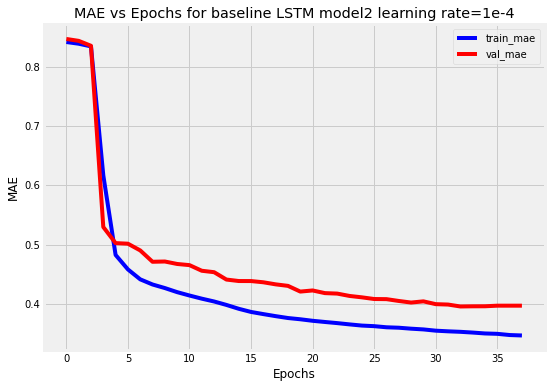

In [ ]:
# Plot the learning curves LSTM model2 with learning rate = 1e-4
N = np.arange(0, len(history_lstm2.history["mae"]))
plt.figure(figsize=(8, 6))
plt.plot(N, history_lstm2.history["mae"],'b-' ,label="train_mae")
plt.plot(N, history_lstm2.history["val_mae"],'r-' ,label="val_mae")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("MAE vs Epochs for baseline LSTM model2 learning rate=1e-4")
plt.legend()

**Build GRU Model**

In [ ]:
def build_gru_model(learning_rate=1e-3):
    gru_model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    keras.layers.GRU(300, return_sequences=True),
    keras.layers.GRU(100, return_sequences=True),
    keras.layers.Dense(1)])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    gru_model.compile(loss=tf.keras.losses.MAE, optimizer=optimizer, metrics=["mae"])
    return gru_model

In [ ]:
# Train the GRU model with learning rate = 1e-3
epochs =100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,restore_best_weights=True)
gru1 = build_gru_model(learning_rate=1e-3)
history_gru1 = gru1.fit(train_dataset,
                         epochs=epochs,
                         validation_data=val_dataset,
                         callbacks=[callback],                      
                         verbose=2)

Epoch 1/100
282/282 - 12s - loss: 0.8377 - mae: 0.8377 - val_loss: 0.8426 - val_mae: 0.8426
Epoch 2/100
282/282 - 8s - loss: 0.8400 - mae: 0.8400 - val_loss: 0.8423 - val_mae: 0.8423
Epoch 3/100
282/282 - 8s - loss: 0.8394 - mae: 0.8394 - val_loss: 0.8447 - val_mae: 0.8447
Epoch 4/100
282/282 - 8s - loss: 0.8408 - mae: 0.8408 - val_loss: 0.8422 - val_mae: 0.8422
Epoch 5/100
282/282 - 8s - loss: 0.6576 - mae: 0.6576 - val_loss: 0.5275 - val_mae: 0.5275
Epoch 6/100
282/282 - 8s - loss: 0.4541 - mae: 0.4541 - val_loss: 0.4788 - val_mae: 0.4788
Epoch 7/100
282/282 - 8s - loss: 0.4035 - mae: 0.4035 - val_loss: 0.4668 - val_mae: 0.4668
Epoch 8/100
282/282 - 8s - loss: 0.3882 - mae: 0.3882 - val_loss: 0.4526 - val_mae: 0.4526
Epoch 9/100
282/282 - 8s - loss: 0.3795 - mae: 0.3795 - val_loss: 0.4550 - val_mae: 0.4550
Epoch 10/100
282/282 - 8s - loss: 0.3691 - mae: 0.3691 - val_loss: 0.4305 - val_mae: 0.4305
Epoch 11/100
282/282 - 8s - loss: 0.3573 - mae: 0.3573 - val_loss: 0.4221 - val_mae: 0.4

In [ ]:
# Train the GRU model with learning rate = 1e-4
gru2 = build_gru_model(learning_rate=1e-4)
history_gru2 = gru2.fit(train_dataset,
                         epochs=epochs,
                         validation_data=val_dataset,
                         callbacks=[callback],                      
                         verbose=2)

Epoch 1/100
282/282 - 12s - loss: 0.8418 - mae: 0.8418 - val_loss: 0.8497 - val_mae: 0.8497
Epoch 2/100
282/282 - 8s - loss: 0.8419 - mae: 0.8419 - val_loss: 0.8495 - val_mae: 0.8495
Epoch 3/100
282/282 - 8s - loss: 0.8404 - mae: 0.8404 - val_loss: 0.8501 - val_mae: 0.8501
Epoch 4/100
282/282 - 8s - loss: 0.8392 - mae: 0.8392 - val_loss: 0.8488 - val_mae: 0.8488
Epoch 5/100
282/282 - 8s - loss: 0.8381 - mae: 0.8381 - val_loss: 0.8457 - val_mae: 0.8457
Epoch 6/100
282/282 - 8s - loss: 0.8371 - mae: 0.8371 - val_loss: 0.8409 - val_mae: 0.8409
Epoch 7/100
282/282 - 8s - loss: 0.8324 - mae: 0.8324 - val_loss: 0.8224 - val_mae: 0.8224
Epoch 8/100
282/282 - 8s - loss: 0.5727 - mae: 0.5727 - val_loss: 0.5242 - val_mae: 0.5242
Epoch 9/100
282/282 - 8s - loss: 0.4782 - mae: 0.4782 - val_loss: 0.4818 - val_mae: 0.4818
Epoch 10/100
282/282 - 8s - loss: 0.4647 - mae: 0.4647 - val_loss: 0.4765 - val_mae: 0.4765
Epoch 11/100
282/282 - 8s - loss: 0.4542 - mae: 0.4542 - val_loss: 0.4711 - val_mae: 0.4

In [ ]:
# Train the GRU model with learning rate = 1e-5
gru3 = build_gru_model(learning_rate=1e-5)
history_gru3 = gru3.fit(train_dataset,
                         epochs=epochs,
                         validation_data=val_dataset,
                         callbacks=[callback],                      
                         verbose=2)


Epoch 1/100
282/282 - 12s - loss: 0.8466 - mae: 0.8466 - val_loss: 0.8603 - val_mae: 0.8603
Epoch 2/100
282/282 - 8s - loss: 0.8444 - mae: 0.8444 - val_loss: 0.8671 - val_mae: 0.8671
Epoch 3/100
282/282 - 8s - loss: 0.8429 - mae: 0.8429 - val_loss: 0.8708 - val_mae: 0.8708
Epoch 4/100
282/282 - 8s - loss: 0.8421 - mae: 0.8421 - val_loss: 0.8722 - val_mae: 0.8722
Epoch 5/100
282/282 - 8s - loss: 0.8416 - mae: 0.8416 - val_loss: 0.8720 - val_mae: 0.8720
Epoch 6/100
282/282 - 8s - loss: 0.8411 - mae: 0.8411 - val_loss: 0.8712 - val_mae: 0.8712


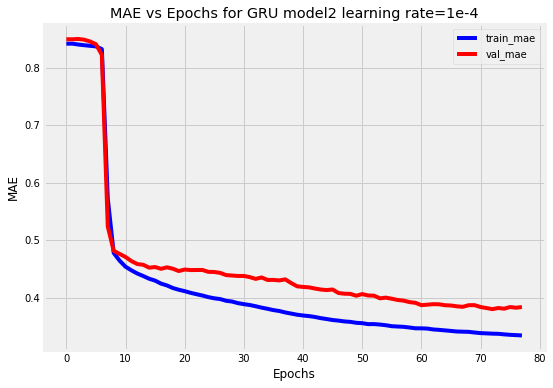

In [ ]:
# Plot the learning curves GRU model2 with learning rate = 1e-4
N = np.arange(0, len(history_gru2.history["mae"]))
plt.figure(figsize=(8, 6))
plt.plot(N, history_gru2.history["mae"],'b-' ,label="train_mae")
plt.plot(N, history_gru2.history["val_mae"],'r-' ,label="val_mae")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("MAE vs Epochs for GRU model2 learning rate=1e-4")
plt.legend()

**Build a GRU model with 3 hidden layers**

In [ ]:
# Build a gru model with 3 hidden layers 
learning_rate = 1e-4
gru4 = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    keras.layers.GRU(300, return_sequences=True),
    keras.layers.GRU(200, return_sequences=True),
    keras.layers.GRU(100, return_sequences=True),
    keras.layers.Dense(1)])
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
gru4.compile(loss=tf.keras.losses.MAE, optimizer=optimizer, metrics=["mae"])

In [ ]:
# Train the GRU model with 3 hidden layers and learning rate = 1e-4
epochs = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,restore_best_weights=True)
history_gru4 = gru4.fit(train_dataset,
                         epochs=epochs,
                         validation_data=val_dataset,
                         callbacks=[callback],                      
                         verbose=2)

Epoch 1/100
282/282 - 14s - loss: 0.8417 - mae: 0.8417 - val_loss: 0.8476 - val_mae: 0.8476
Epoch 2/100
282/282 - 9s - loss: 0.8415 - mae: 0.8415 - val_loss: 0.8438 - val_mae: 0.8438
Epoch 3/100
282/282 - 9s - loss: 0.8399 - mae: 0.8399 - val_loss: 0.8493 - val_mae: 0.8493
Epoch 4/100
282/282 - 9s - loss: 0.8389 - mae: 0.8389 - val_loss: 0.8459 - val_mae: 0.8459
Epoch 5/100
282/282 - 10s - loss: 0.8385 - mae: 0.8385 - val_loss: 0.8447 - val_mae: 0.8447
Epoch 6/100
282/282 - 10s - loss: 0.8374 - mae: 0.8374 - val_loss: 0.8410 - val_mae: 0.8410
Epoch 7/100
282/282 - 9s - loss: 0.8368 - mae: 0.8368 - val_loss: 0.8379 - val_mae: 0.8379
Epoch 8/100
282/282 - 9s - loss: 0.8343 - mae: 0.8343 - val_loss: 0.8300 - val_mae: 0.8300
Epoch 9/100
282/282 - 9s - loss: 0.6283 - mae: 0.6283 - val_loss: 0.5561 - val_mae: 0.5561
Epoch 10/100
282/282 - 9s - loss: 0.4929 - mae: 0.4929 - val_loss: 0.5929 - val_mae: 0.5929
Epoch 11/100
282/282 - 10s - loss: 0.4623 - mae: 0.4623 - val_loss: 0.5549 - val_mae: 

In [ ]:
# gru4 test dataset loss 
gru4_test_loss = gru4.evaluate(test_dataset, steps=35)
print('GRU4 test MAE:', gru4_test_loss[1])

35/35 [==============================] - 3s 13ms/step - loss: 0.3077 - mae: 0.3077
GRU4 test MAE: 0.30770665407180786


In [ ]:
# Predict test_dataset 
gru4_forecast = gru4.predict(test_dataset)


In [ ]:
# predictions of test_data
gru4_forecast_test = gru4_forecast[:,0]

In [ ]:
# Invserse transform forecast data
gru4_forecast_inv = scaler.inverse_transform(gru4_forecast_test)

In [ ]:
# Get the original test data less last window 
window_size =96
test_data = scaler.inverse_transform(test_ds)
actual_load = []
for y in test_data[:len(test_ds)-window_size]:
    actual_load.append(y)

In [ ]:
# gru4 model MWh error
from sklearn.metrics import mean_absolute_error
gru4_error = mean_absolute_error(np.array(actual_load), gru4_forecast_inv.flatten())
print('GRU4 Model error:{} MWh'.format(gru4_error))

GRU4 Model error:69.93889255240856 MWh


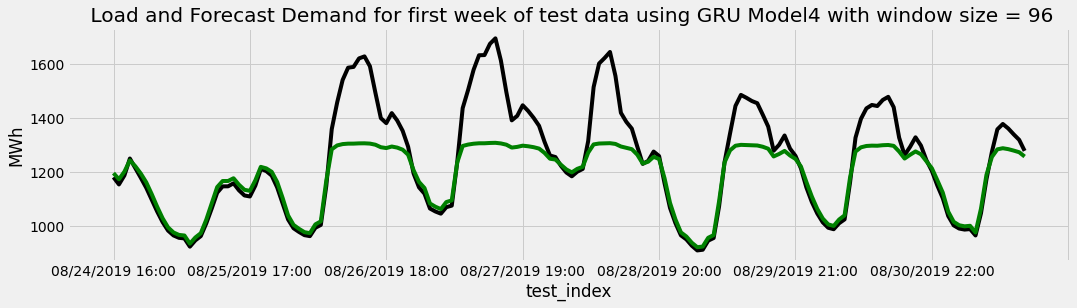

In [ ]:
# Plot the test load demand and forecast load demand for the first of test data using GRU4
test = scaler.inverse_transform(test_ds)
gru4_forecast_inv_flatten =  gru4_forecast_inv.flatten()
forecast_gru4_testdata = {'test_index':test_index[:168],'test_load':test[:168],'test_forecast':gru4_forecast_inv_flatten[:168]}
forecast_gru4_testdata = pd.DataFrame(forecast_gru4_testdata)
forecast_gru4_testdata.set_index('test_index', inplace=True)
plt.style.use('fivethirtyeight')
plt.figure(figsize = (16,4))
plt.grid(False)
forecast_gru4_testdata.test_load.plot(color="black")
forecast_gru4_testdata.test_forecast.plot(color="green")
plt.title(' Load and Forecast Demand for first week of test data using GRU Model4 with window size = 96')           
plt.ylabel('MWh')
plt.legend()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/3546 Deep Learning/Final Project/load_forecast_gru4.png')

**Build GRU model using a 1D convolutional layer**

In [ ]:
# Build a GRU model using a 1D convolutional layer
learning_rate = 1e-4
gru5 = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),                            
    keras.layers.Conv1D(filters=200, kernel_size=2, strides=1, padding="same"),
    keras.layers.GRU(200, return_sequences=True),
    keras.layers.GRU(100, return_sequences=True),
    keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
gru5.compile(loss=tf.keras.losses.MAE, optimizer=optimizer, metrics=["mae"])

In [ ]:
# Train GRU model using a 1D convolutional layer
history_gru5 = gru5.fit(train_dataset,
                         epochs=epochs,
                         validation_data=val_dataset,
                         callbacks=[callback],                      
                         verbose=2)

Epoch 1/100
282/282 - 26s - loss: 0.8409 - mae: 0.8409 - val_loss: 0.8395 - val_mae: 0.8395
Epoch 2/100
282/282 - 8s - loss: 0.8372 - mae: 0.8372 - val_loss: 0.8294 - val_mae: 0.8294
Epoch 3/100
282/282 - 8s - loss: 0.6831 - mae: 0.6831 - val_loss: 0.6056 - val_mae: 0.6056
Epoch 4/100
282/282 - 8s - loss: 0.5601 - mae: 0.5601 - val_loss: 0.5734 - val_mae: 0.5734
Epoch 5/100
282/282 - 8s - loss: 0.5494 - mae: 0.5494 - val_loss: 0.5649 - val_mae: 0.5649
Epoch 6/100
282/282 - 9s - loss: 0.5528 - mae: 0.5528 - val_loss: 0.5505 - val_mae: 0.5505
Epoch 7/100
282/282 - 9s - loss: 0.5459 - mae: 0.5459 - val_loss: 0.5500 - val_mae: 0.5500
Epoch 8/100
282/282 - 9s - loss: 0.5408 - mae: 0.5408 - val_loss: 0.5502 - val_mae: 0.5502
Epoch 9/100
282/282 - 8s - loss: 0.5354 - mae: 0.5354 - val_loss: 0.5496 - val_mae: 0.5496
Epoch 10/100
282/282 - 8s - loss: 0.5281 - mae: 0.5281 - val_loss: 0.5509 - val_mae: 0.5509
Epoch 11/100
282/282 - 8s - loss: 0.5123 - mae: 0.5123 - val_loss: 0.5253 - val_mae: 0.5

**Build a wavenet**

In [ ]:
# Build a wavenet
wavenet = keras.models.Sequential()
wavenet.add(keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]))
for rate in (1, 2, 4, 8) * 2:
    wavenet.add(keras.layers.Conv1D(filters=200, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
wavenet.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
wavenet.compile(loss=tf.keras.losses.MAE, optimizer=optimizer, metrics=["mae"])
wavenet.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_19 (Lambda)           (None, None, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 200)         600       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 200)         80200     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 200)         80200     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 200)         80200     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 200)         80200     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 200)       

In [ ]:
# Train wavenet model
history_wavenet = wavenet.fit(train_dataset,
                         epochs=epochs,
                         validation_data=val_dataset,
                         callbacks=[callback],                      
                         verbose=2)

Epoch 1/100
282/282 - 11s - loss: 0.8138 - mae: 0.8138 - val_loss: 0.7567 - val_mae: 0.7567
Epoch 2/100
282/282 - 7s - loss: 0.7424 - mae: 0.7424 - val_loss: 0.7511 - val_mae: 0.7511
Epoch 3/100
282/282 - 7s - loss: 0.7219 - mae: 0.7219 - val_loss: 0.7336 - val_mae: 0.7336
Epoch 4/100
282/282 - 7s - loss: 0.7122 - mae: 0.7122 - val_loss: 0.7334 - val_mae: 0.7334
Epoch 5/100
282/282 - 7s - loss: 0.7061 - mae: 0.7061 - val_loss: 0.7294 - val_mae: 0.7294
Epoch 6/100
282/282 - 7s - loss: 0.7017 - mae: 0.7017 - val_loss: 0.7273 - val_mae: 0.7273
Epoch 7/100
282/282 - 7s - loss: 0.6986 - mae: 0.6986 - val_loss: 0.7243 - val_mae: 0.7243
Epoch 8/100
282/282 - 7s - loss: 0.6961 - mae: 0.6961 - val_loss: 0.7220 - val_mae: 0.7220
Epoch 9/100
282/282 - 7s - loss: 0.6948 - mae: 0.6948 - val_loss: 0.7228 - val_mae: 0.7228
Epoch 10/100
282/282 - 7s - loss: 0.6931 - mae: 0.6931 - val_loss: 0.7206 - val_mae: 0.7206
Epoch 11/100
282/282 - 7s - loss: 0.6915 - mae: 0.6915 - val_loss: 0.7182 - val_mae: 0.7

**Build a 3 layer GRU model with hyperparameters; window size = 168 and learning rate = 1e-4** 

In [ ]:
# Build a gru model with 3 hidden layers; use hyperparameters window size =168 and learning rate = 1e-4 
learning_rate = 1e-4
gru6 = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    keras.layers.GRU(300, return_sequences=True),
    keras.layers.GRU(200, return_sequences=True),
    keras.layers.GRU(100, return_sequences=True),
    keras.layers.Dense(1)])
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
gru6.compile(loss=tf.keras.losses.MAE, optimizer=optimizer, metrics=["mae"])

In [ ]:
learning_rate = 1e-4
window_size = 168
batch_size = 256
shuffle_buffer = 256

train_dataset1 = windowed_dataset(train_ds, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer)
val_dataset1 = windowed_dataset(val_ds, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer)
test_dataset1 = windowed_dataset_test(test_ds, window_size=window_size)

In [ ]:
# Train the GRU model with 3 hidden layers, learning rate = 1e-4 and window size = 168
epochs = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,restore_best_weights=True)
history_gru6 = gru6.fit(train_dataset1,
                         epochs=epochs,
                         validation_data=val_dataset1,
                         callbacks=[callback],                      
                         verbose=2)

Epoch 1/100
141/141 - 15s - loss: 0.8435 - mae: 0.8435 - val_loss: 0.8547 - val_mae: 0.8547
Epoch 2/100
141/141 - 10s - loss: 0.8435 - mae: 0.8435 - val_loss: 0.8558 - val_mae: 0.8558
Epoch 3/100
141/141 - 11s - loss: 0.8420 - mae: 0.8420 - val_loss: 0.8571 - val_mae: 0.8571
Epoch 4/100
141/141 - 11s - loss: 0.8417 - mae: 0.8417 - val_loss: 0.8568 - val_mae: 0.8568
Epoch 5/100
141/141 - 10s - loss: 0.8413 - mae: 0.8413 - val_loss: 0.8564 - val_mae: 0.8564
Epoch 6/100
141/141 - 10s - loss: 0.8407 - mae: 0.8407 - val_loss: 0.8551 - val_mae: 0.8551


**Build a 3 layer GRU model with hyperparameters; window size = 72 and learning rate = 1e-4**

In [ ]:
# Build a gru model with 3 hidden layers; use hyperparameters window size = 72 and learning rate = 1e-4
learning_rate = 1e-4
gru7 = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    keras.layers.GRU(300, return_sequences=True),
    keras.layers.GRU(200, return_sequences=True),
    keras.layers.GRU(100, return_sequences=True),
    keras.layers.Dense(1)])
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
gru7.compile(loss=tf.keras.losses.MAE, optimizer=optimizer, metrics=["mae"])

In [ ]:
window_size = 72
batch_size = 128
shuffle_buffer = 128

train_dataset2 = windowed_dataset(train_ds, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer)
val_dataset2 = windowed_dataset(val_ds, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer)
test_dataset2 = windowed_dataset_test(test_ds, window_size=window_size)

In [ ]:
# Train the GRU model with 3 hidden layers, learning rate = 1e-4 and window size = 72
epochs = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,restore_best_weights=True)
history_gru7 = gru7.fit(train_dataset2,
                         epochs=epochs,
                         validation_data=val_dataset2,
                         callbacks=[callback],                      
                         verbose=2)

Epoch 1/100
282/282 - 13s - loss: 0.8386 - mae: 0.8386 - val_loss: 0.8345 - val_mae: 0.8345
Epoch 2/100
282/282 - 8s - loss: 0.8350 - mae: 0.8350 - val_loss: 0.8324 - val_mae: 0.8324
Epoch 3/100
282/282 - 8s - loss: 0.8334 - mae: 0.8334 - val_loss: 0.8312 - val_mae: 0.8312
Epoch 4/100
282/282 - 9s - loss: 0.8321 - mae: 0.8321 - val_loss: 0.8304 - val_mae: 0.8304
Epoch 5/100
282/282 - 9s - loss: 0.8298 - mae: 0.8298 - val_loss: 0.8295 - val_mae: 0.8295
Epoch 6/100
282/282 - 8s - loss: 0.6783 - mae: 0.6783 - val_loss: 0.6930 - val_mae: 0.6930
Epoch 7/100
282/282 - 8s - loss: 0.5463 - mae: 0.5463 - val_loss: 0.7132 - val_mae: 0.7132
Epoch 8/100
282/282 - 9s - loss: 0.5023 - mae: 0.5023 - val_loss: 0.5392 - val_mae: 0.5392
Epoch 9/100
282/282 - 8s - loss: 0.4556 - mae: 0.4556 - val_loss: 0.4469 - val_mae: 0.4469
Epoch 10/100
282/282 - 8s - loss: 0.4293 - mae: 0.4293 - val_loss: 0.4463 - val_mae: 0.4463
Epoch 11/100
282/282 - 8s - loss: 0.4163 - mae: 0.4163 - val_loss: 0.4546 - val_mae: 0.4

**Build a GRU model with hperparameters; learning rate = 1e-4, window_size = 72 dropout = 0.4.**

In [ ]:
#Build a GRU model with hperparameters; learning rate = 1e-4, window_size = 72 dropout = 0.4
learning_rate = 1e-4
gru8 = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    keras.layers.GRU(300, dropout=0.4,return_sequences=True),
    keras.layers.GRU(200, dropout=0.4, return_sequences=True),
    keras.layers.GRU(100, dropout=0.4, return_sequences=True),
    keras.layers.Dense(1)])
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
gru8.compile(loss=tf.keras.losses.MAE, optimizer=optimizer, metrics=["mae"])

In [ ]:
epochs = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,restore_best_weights=True)
history_gru8 = gru8.fit(train_dataset2,
                         epochs=epochs,
                         validation_data=val_dataset2,
                         callbacks=[callback],                      
                         verbose=2)

Epoch 1/100
282/282 - 14s - loss: 0.8398 - mae: 0.8398 - val_loss: 0.8375 - val_mae: 0.8375
Epoch 2/100
282/282 - 8s - loss: 0.8378 - mae: 0.8378 - val_loss: 0.8363 - val_mae: 0.8363
Epoch 3/100
282/282 - 8s - loss: 0.8366 - mae: 0.8366 - val_loss: 0.8350 - val_mae: 0.8350
Epoch 4/100
282/282 - 8s - loss: 0.8360 - mae: 0.8360 - val_loss: 0.8326 - val_mae: 0.8326
Epoch 5/100
282/282 - 9s - loss: 0.8349 - mae: 0.8349 - val_loss: 0.8321 - val_mae: 0.8321
Epoch 6/100
282/282 - 9s - loss: 0.8345 - mae: 0.8345 - val_loss: 0.8308 - val_mae: 0.8308
Epoch 7/100
282/282 - 8s - loss: 0.8332 - mae: 0.8332 - val_loss: 0.8295 - val_mae: 0.8295
Epoch 8/100
282/282 - 8s - loss: 0.7445 - mae: 0.7445 - val_loss: 0.5937 - val_mae: 0.5937
Epoch 9/100
282/282 - 8s - loss: 0.5389 - mae: 0.5389 - val_loss: 0.5513 - val_mae: 0.5513
Epoch 10/100
282/282 - 8s - loss: 0.5013 - mae: 0.5013 - val_loss: 0.5336 - val_mae: 0.5336
Epoch 11/100
282/282 - 8s - loss: 0.4831 - mae: 0.4831 - val_loss: 0.4955 - val_mae: 0.4

**GRU model 9;GRU model with 3 hidden layers, learning rate = 1e-4, window size = 48**

In [ ]:
# Build a gru model with 3 hidden layers; use hyperparameters window size = 48 and learning rate = 1e-4
learning_rate = 1e-4
gru9 = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    keras.layers.GRU(300, return_sequences=True),
    keras.layers.GRU(200, return_sequences=True),
    keras.layers.GRU(100, return_sequences=True),
    keras.layers.Dense(1)])
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
gru9.compile(loss=tf.keras.losses.MAE, optimizer=optimizer, metrics=["mae"])

In [ ]:
window_size = 48
batch_size = 128
shuffle_buffer = 128

train_dataset3 = windowed_dataset(train_ds, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer)
val_dataset3 = windowed_dataset(val_ds, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer)
test_dataset3 = windowed_dataset_test(test_ds, window_size=window_size)

In [ ]:
epochs = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,restore_best_weights=True)
history_gru9 = gru9.fit(train_dataset3,
                         epochs=epochs,
                         validation_data=val_dataset3,
                         callbacks=[callback],                      
                         verbose=2)

Epoch 1/100
283/283 - 11s - loss: 0.8317 - mae: 0.8317 - val_loss: 0.8208 - val_mae: 0.8208
Epoch 2/100
283/283 - 6s - loss: 0.8181 - mae: 0.8181 - val_loss: 0.8151 - val_mae: 0.8151
Epoch 3/100
283/283 - 6s - loss: 0.8137 - mae: 0.8137 - val_loss: 0.8067 - val_mae: 0.8067
Epoch 4/100
283/283 - 6s - loss: 0.6916 - mae: 0.6916 - val_loss: 0.5594 - val_mae: 0.5594
Epoch 5/100
283/283 - 6s - loss: 0.4770 - mae: 0.4770 - val_loss: 0.4841 - val_mae: 0.4841
Epoch 6/100
283/283 - 7s - loss: 0.4290 - mae: 0.4290 - val_loss: 0.4576 - val_mae: 0.4576
Epoch 7/100
283/283 - 7s - loss: 0.4065 - mae: 0.4065 - val_loss: 0.4442 - val_mae: 0.4442
Epoch 8/100
283/283 - 7s - loss: 0.3936 - mae: 0.3936 - val_loss: 0.4259 - val_mae: 0.4259
Epoch 9/100
283/283 - 6s - loss: 0.3832 - mae: 0.3832 - val_loss: 0.4135 - val_mae: 0.4135
Epoch 10/100
283/283 - 6s - loss: 0.3752 - mae: 0.3752 - val_loss: 0.4136 - val_mae: 0.4136
Epoch 11/100
283/283 - 6s - loss: 0.3687 - mae: 0.3687 - val_loss: 0.4026 - val_mae: 0.4

In [ ]:
gru9.save("gru9_model.h5")

In [ ]:
# gru9 test dataset loss 
gru9_test_loss = gru9.evaluate(test_dataset3, steps=35)
print('GRU9 test MAE:', gru9_test_loss[1])

35/35 [==============================] - 3s 9ms/step - loss: 0.7153 - mae: 0.7153
GRU9 test MAE: 0.7153483033180237


**GRU model 10;GRU model with 3 hidden layers, learning rate = 1e-4, window size = 24**

In [ ]:
learning_rate = 1e-4
gru10 = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    keras.layers.GRU(300,return_sequences=True),
    keras.layers.GRU(200,return_sequences=True),
    keras.layers.GRU(100,return_sequences=True),
    keras.layers.Dense(1)])
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
gru10.compile(loss=tf.keras.losses.MAE, optimizer=optimizer, metrics=["mae"])

In [ ]:
window_size = 24
batch_size = 128
shuffle_buffer = 128

train_dataset4 = windowed_dataset(train_ds, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer)
val_dataset4 = windowed_dataset(val_ds, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer)
test_dataset4 = windowed_dataset_test(test_ds, window_size=window_size)

In [ ]:
epochs = 100
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5,restore_best_weights=True)
history_gru10 = gru10.fit(train_dataset4,
                         epochs=epochs,
                         validation_data=val_dataset4,
                         callbacks=[callback],                      
                         verbose=2)

Epoch 1/100
283/283 - 11s - loss: 0.7808 - mae: 0.7808 - val_loss: 0.6610 - val_mae: 0.6610
Epoch 2/100
283/283 - 5s - loss: 0.5990 - mae: 0.5990 - val_loss: 0.5443 - val_mae: 0.5443
Epoch 3/100
283/283 - 5s - loss: 0.4304 - mae: 0.4304 - val_loss: 0.4086 - val_mae: 0.4086
Epoch 4/100
283/283 - 5s - loss: 0.3792 - mae: 0.3792 - val_loss: 0.4048 - val_mae: 0.4048
Epoch 5/100
283/283 - 5s - loss: 0.3705 - mae: 0.3705 - val_loss: 0.3854 - val_mae: 0.3854
Epoch 6/100
283/283 - 5s - loss: 0.3643 - mae: 0.3643 - val_loss: 0.3817 - val_mae: 0.3817
Epoch 7/100
283/283 - 5s - loss: 0.3584 - mae: 0.3584 - val_loss: 0.3748 - val_mae: 0.3748
Epoch 8/100
283/283 - 5s - loss: 0.3530 - mae: 0.3530 - val_loss: 0.3732 - val_mae: 0.3732
Epoch 9/100
283/283 - 5s - loss: 0.3468 - mae: 0.3468 - val_loss: 0.3659 - val_mae: 0.3659
Epoch 10/100
283/283 - 5s - loss: 0.3396 - mae: 0.3396 - val_loss: 0.3635 - val_mae: 0.3635
Epoch 11/100
283/283 - 5s - loss: 0.3328 - mae: 0.3328 - val_loss: 0.3567 - val_mae: 0.3

In [ ]:
gru10.save("gru10_model.h5")

In [ ]:
#gru10 = keras.models.load_model("gru10_model.h5")

**Best model: GRU model 10 with 3 hidden layers; learning rate = 1e-4 and window size = 24**

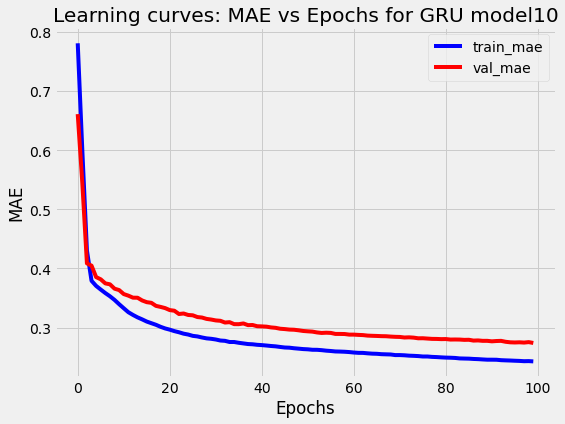

In [ ]:
# Plot the learning curves GRU model10 
N = np.arange(0, len(history_gru10.history["mae"]))
plt.figure(figsize=(8, 6))
plt.plot(N, history_gru10.history["mae"],'b-' ,label="train_mae")
plt.plot(N, history_gru10.history["val_mae"],'r-' ,label="val_mae")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Learning curves: MAE vs Epochs for GRU model10")
plt.legend()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/3546 Deep Learning/Final Project/learning_curves_gru10.png')
plt.show()

In [ ]:
# gru10 test dataset loss 
gru10_test_loss = gru10.evaluate(test_dataset4, steps=35)
print('GRU10 test MAE:', gru10_test_loss[1])

35/35 [==============================] - 1s 6ms/step - loss: 0.3471 - mae: 0.3471
GRU10 test MAE: 0.34707406163215637


In [ ]:
# Predict the test_dataset4 
gru10_forecast = gru10.predict(test_dataset4)

In [ ]:
# predictions of test_data4
gru10_forecast_test = gru10_forecast[:,0]

In [ ]:
# Invserse transform forecast data
gru10_forecast_inv = scaler.inverse_transform(gru10_forecast_test)

In [ ]:
# Get the original test data less one window size of test data
window_size =24
test_data4 = scaler.inverse_transform(test_ds)
actual_load4 = []
for y in test_data4[:len(test_ds)-window_size]:
    actual_load4.append(y)

In [ ]:
# gru10 model error
from sklearn.metrics import mean_absolute_error
gru10_error = mean_absolute_error(np.array(actual_load4), gru10_forecast_inv.flatten())
print('GRU10 MAE error:{} MWh'.format(gru10_error))

GRU10 MAE error:17.94541266444739 MWh


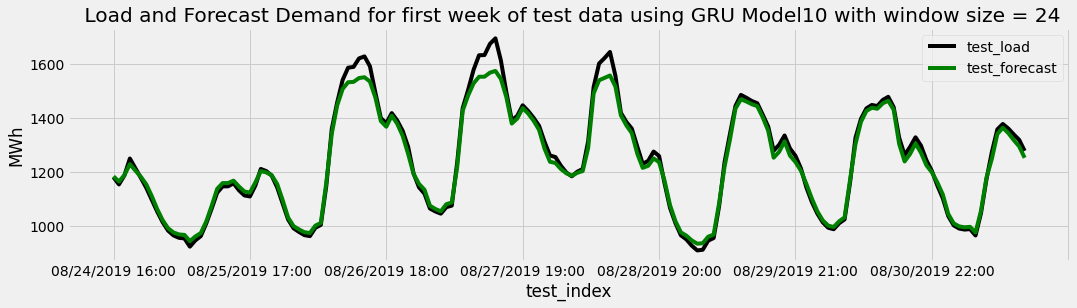

In [ ]:
# Plot the test load demand and forecast load demand for the first week of test data using GRU10
test = scaler.inverse_transform(test_ds)
gru10_forecast_inv_flatten =  gru10_forecast_inv.flatten()
forecast_gru10_testdata = {'test_index':test_index[:168],'test_load':test[:168],'test_forecast':gru10_forecast_inv_flatten[:168]}
forecast_gru10_testdata = pd.DataFrame(forecast_gru10_testdata)
forecast_gru10_testdata.set_index('test_index', inplace=True)
plt.style.use('fivethirtyeight')
plt.figure(figsize = (16,4))
plt.grid(False)
forecast_gru10_testdata.test_load.plot(color="black")
forecast_gru10_testdata.test_forecast.plot(color="green")
plt.title(' Load and Forecast Demand for first week of test data using GRU Model10 with window size = 24')          
plt.ylabel('MWh')
plt.legend()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/3546 Deep Learning/Final Project/load_forecast_gru10.png')

In [ ]:
# Generate 6 hrs predictions beyond the test data
window_size = 24
last_test_window = test_ds[-window_size:]
for step_ahead in range(6):
  Y_pred_last = gru10.predict(last_test_window[-window_size:])[-1].flatten()
  last_test_window = np.append(last_test_window[-window_size:], Y_pred_last)

Y_pred = last_test_window[-6:] 

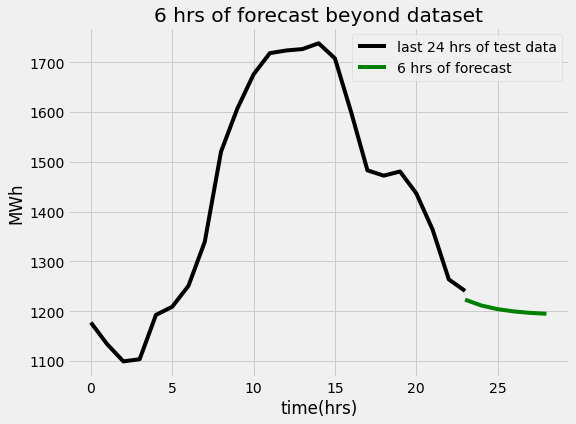

In [ ]:
# Plot predictions beyond dataset
x1_axis = np.linspace(0, 23, 24)
x2_axis = np.linspace(23, 28, 6)
last_24hr = test_ds[-window_size:]
last_24hr = scaler.inverse_transform(last_24hr)
Y_pred = scaler.inverse_transform(Y_pred)
plt.figure(figsize = (8,6))
plt.style.use('fivethirtyeight')
plt.plot(x1_axis,last_24hr, "k-", label ='last 24 hrs of test data')
plt.plot(x2_axis,Y_pred, "g-", label = '6 hrs of forecast')
plt.title('6 hrs of forecast beyond dataset')
plt.xlabel('time(hrs)')
plt.ylabel('MWh')
plt.legend()
plt.savefig('/content/gdrive/My Drive/Colab Notebooks/3546 Deep Learning/Final Project/load_forecast_gru10_6hrs.png')